# Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sympy as sy
from random import sample
from random import seed as rn_seed
import os
import imageio

# Modelo Discreto

In [2]:
class sistema1: 
    #Método iniciador
    def __init__(self, N = 500, M = 5*10**5, nu = 0.05):
        self.N = N #Número de agentes
        self.M = M # Cantidad de dinero en circulación
        self.delta = nu*M/N #monto de dinero intercambiado entre agentes
       
    #Método que dado un tiempo tau, escoge a un perdedor y ganador factibles en el tiempo dado     
    def transactores(self, tau):
        p,g = np.random.choice(self.N, 2) #sampleamos dos personas
        while self.mm[p,tau]< self.delta:
            p,g = np.random.choice(self.N, 2) #sampleamos hasta que el perdedor tenga dinero suficiente
        return p,g
    
    #Método que realiza la simulación en tiempo tau
    def simular(self, tiempo = 4*10**5):
        self.tiempo = tiempo
        self.mm = np.zeros([self.N,self.tiempo]) #Matriz cuyas filas son la distribución de dinero en cada tiempo (estado)
        self.mm[:,0] = np.ones(self.N)*(self.M/self.N) #En tiempo 0 todos parten con M/N unidades de dinero
        for t in range(1, tiempo):
            self.mm[:,t]+= self.mm[:,t-1] #igualamos el estado actual al anterior
            p,g= self.transactores(t)
            self.mm[p,t]-= self.delta
            self.mm[g,t]+= self.delta

    #Método que retorna la evolución de los estados
    def cadena(self):
        return self.mm
    
    #Método que genera la distribución empírica y la distribución BG normalizada a los estados finales 
    #### quizá esto debería ir en simular y guardarse en estados de la clase ####
    def distribuciones(self, tau = -1):
        ### Densidad Empírica
        cadena_en_tau = self.mm[:,tau].copy()
        estados, frec =  np.unique(cadena_en_tau, return_counts=True) #valores únicos de riqueza y su 
                                                                     #frecuencia absoluta
        dist_emp = frec/np.sum(frec) #densidad empírica de probabilidad (frecuencia relativa de aparición)
        #La probabilidad de que un agente tenga estados[i] plata es dist_emp[i]
        
        ###Densidad modelo: pi \prop exp(-x/T)
        ##pi(x) = exp(-x/T)/ [sum_{i\in estados} exp(-i/T)
        T = self.M/self.N
        cte_norm = np.sum([np.exp(-i/T) for i in estados])
        pi = lambda x: (1/cte_norm)*np.exp(-x/T)
        
        return dist_emp, pi(estados)
    
    #Método que retorna el error cuadrático medio entre distribución empírica y distribución modelada
    def ECM(self, tau = -1):
        dist_emp, dist_modelo = self.distribuciones(tau)
        return np.square(dist_emp-dist_modelo).mean()
    
    #Método que grafica la distribución de dinero en tiempo tau
    def graficar(self, tau = -1, par_bins='auto', density = True):
        plt.title(f' Sistema Discreto \n N={self.N}, M={self.M}, $\Delta m$={self.delta}, $T_f$={self.tiempo}')
        if density==True:
            plt.hist(self.mm[:,tau], bins= par_bins, density = True)
            
            T = self.M/self.N
            f = lambda x: (1/T)*np.exp(-x/T)
            lim = np.max(self.mm[:,tau])
            v = np.linspace(0,lim,100)
            plt.plot(v,f(v), label = "Boltzmann-Gibbs")
            plt.legend(loc='upper right')
            plt.xlabel('Unidades de Dinero')
            plt.ylabel('Frecuencia Normalizada')
        else:
            plt.hist(self.mm[:,tau], bins= par_bins)
            
    #Método que genera un gif con la evolución del sistema
    def generar_gif(self,nombre_gif, par_bins='auto', density = True):
        ### GIF de la evolución del sistema
        filenames = []
        contador=0
        for i in np.arange(0,self.tiempo,self.tiempo//30):
            contador+=1
            # ploteamos para cada i la distribución en el tiempo i
            plt.title(f'Sistema Discreto \n N={self.N}, M={self.M}, $\Delta m$={self.delta},$T_f$={self.tiempo}')
            if density==True:
                plt.hist(self.mm[:,i], bins= par_bins, density = True)
            
                T = self.M/self.N
                f = lambda x: (1/T)*np.exp(-x/T)
                lim = np.max(self.mm[:,-1])
                v = np.linspace(0,lim,100)
                plt.plot(v,f(v), label = "Boltzmann-Gibbs")
                plt.legend(loc='upper right')
                plt.xlabel('Unidades de Dinero')
                plt.ylabel('Frecuencia Normalizada')
            else:
                plt.hist(self.mm[:,i], bins=par_bins)
                
            # creamos un nombre para el archivo de la imagen
            filename = f'{contador}.png'
            filenames.append(filename)

            # en el último tiempo creamos varias replicas para congelar la imagen
            if (i == np.arange(0,self.tiempo,self.tiempo//30)[-1]):
                for i in range(15):
                    filenames.append(filename)
            # guardamos el(los) frame(s)
            plt.savefig(filename)
            plt.close()# build gif
        with imageio.get_writer(nombre_gif+'.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.v2.imread(filename)
                writer.append_data(image)

        # eliminamos los archivos creados
        for filename in set(filenames):
            os.remove(filename)

### Simulación, gráfico y error cuadrático final

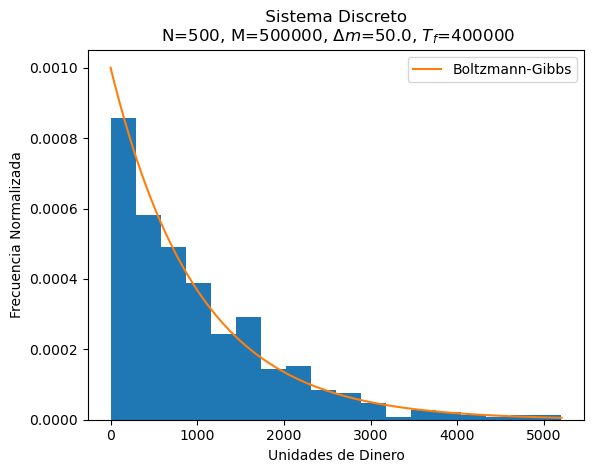

ecm = 2.6421273810838003e-05


In [3]:
##Inicialización de semillas
np.random.seed(43)

##Prueba de simulación
prueba11 = sistema1()
prueba11.simular()
prueba11.graficar()
plt.show()
prueba11.generar_gif('modelo1simulacion1')

ecm = prueba11.ECM()
print(f'ecm = {ecm}')

### Evolución del error cuadrático

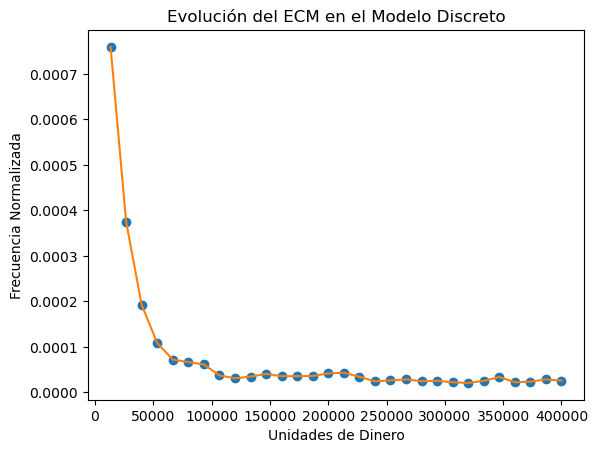

In [4]:
tiempo = 4*10**5
v = np.arange(0,tiempo,tiempo//30)
ecms = [prueba11.ECM(i) for i in v]

plt.plot(v[1:],ecms[1:], "o")
plt.plot(v[1:],ecms[1:])

plt.title('Evolución del ECM en el Modelo Discreto')
plt.xlabel('Unidades de Dinero')
plt.ylabel('Frecuencia Normalizada')
plt.show()

### Error cuadrático medio de 100 simulaciones 

In [5]:
ecms = []
for i in range(100):
    prueba11.simular()
    ecms.append(prueba11.ECM())
resultado = np.mean(ecms)
print(resultado)

2.755580204038046e-05


### Simulación con otros parámetros

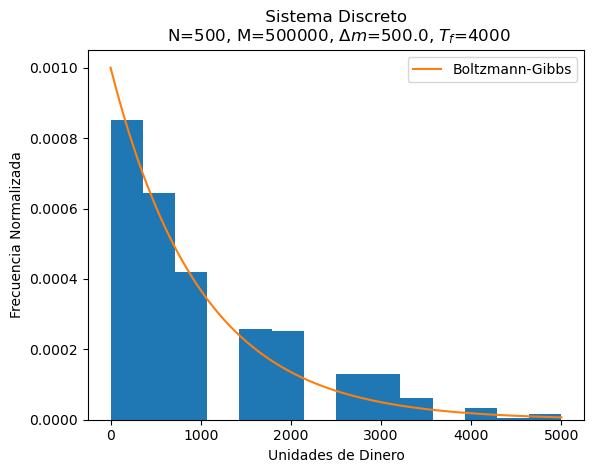

ecm = 0.0009798514752176362


In [6]:
##Inicialización de semillas
np.random.seed(43)

##Prueba de simulación
prueba12 = sistema1( N = 500, M = 5*10**5, nu = 0.5)
prueba12.simular(tiempo = 4*10**3)
prueba12.graficar()
plt.show()
prueba12.generar_gif('modelo1simulacion2')

ecm = prueba12.ECM()
print(f'ecm = {ecm}')

# Modelo con estados continuos

In [7]:
class sistema2:
    #Método iniciador (norm: normalizado o no)
    def __init__(self, N = 500, M = 5*10**5, normal = True):
        self.normal = normal
        self.N = N #Número de agentes
        self.M = M # Cantidad de dinero en circulación
        if self.normal:
            self.M=1

    #Método que realiza la simulación en tiempo tau
    def simular(self, tiempo = 4*10**3):
        self.tiempo = tiempo
        self.mm = np.zeros([self.N,self.tiempo]) #Matriz cuyas filas son la distribución de dinero en cada tiempo (estado)
        self.mm[:,0] = np.ones(self.N)*(self.M/self.N) #En tiempo 0 todos parten con M/N unidades de dinero
        u = np.random.uniform(size = tiempo) #Uniformes a utilizar
        for t in range(1, self.tiempo):
            self.mm[:,t]+= self.mm[:,t-1] #igualamos el estado actual al anterior
            p,g = np.random.choice(self.N, 2) #sampleamos dos transactores aleatorios sin restricción
            fondo = self.mm[p,t] + self.mm[g,t]
            self.mm[p,t] = u[t]*fondo
            self.mm[g,t] = (1-u[t])*fondo
    #Método que retorna la evolución de los estados
    def cadena(self):
        return self.mm
    
    #Método que grafica la distribución de dinero en tiempo tau
    def graficar(self, tau = -1, par_bins='auto', density = True):
        #Definición del título
        plt.title(f'Sistema Continuo\n N={self.N}, M={self.M},$T_f$={self.tiempo}')
        if self.normal:
            plt.title(f'Sistema Continuo\n N={self.N}, $T_f$={self.tiempo}')
        #Gráfico
        if density:
            #Histograma normalizado
            plt.hist(self.mm[:,tau], bins= par_bins, density = True)
            #B-G para comparar
            T = self.M/self.N
            f = lambda x: (1/T)*np.exp(-x/T)
            lim = np.max(self.mm[:,tau])
            v = np.linspace(0,lim,100)
            plt.plot(v,f(v), label = "Boltzmann-Gibbs")
            plt.legend(loc='upper right')
            plt.xlabel('Unidades de Dinero')
            plt.ylabel('Frecuencia Normalizada')
        else:
            #Histograma sin normalizar
            plt.hist(self.mm[:,tau], bins= par_bins)
            
    #Método que genera un gif con la evolución del sistema
    def generar_gif(self,nombre_gif, par_bins='auto', density = True):
        ### GIF de la evolución del sistema
        filenames = []
        contador = 0
        for i in np.arange(0,self.tiempo,self.tiempo//30):
            contador+=1
            # ploteamos para cada i la distribución en el tiempo i
            plt.title(f'Sistema Continuo\n N={self.N}, M={self.M},$T_f$={self.tiempo}')
            if self.normal==True:
                plt.title(f'Sistema Continuo\n N={self.N},$T_f$={self.tiempo}')
            if density==True:
                plt.hist(self.mm[:,i], bins= par_bins, density = True)
            
                T = self.M/self.N
                f = lambda x: (1/T)*np.exp(-x/T)
                lim = np.max(self.mm[:,i])
                v = np.linspace(0,lim,100)
                plt.plot(v,f(v), label = "Boltzmann-Gibbs")
                plt.legend(loc='upper right')
                plt.xlabel('Unidades de Dinero')
                plt.ylabel('Frecuencia Normalizada')
            else:
                plt.hist(self.mm[:,i], bins=par_bins)

                
            # creamos un nombre para el archivo de la imagen
            filename = f'{contador}.png'
            filenames.append(filename)

            # en el último tiempo creamos varias replicas para congelar la imagen
            if (i == np.arange(0,self.tiempo,self.tiempo//30)[-1]):
                for i in range(15):
                    filenames.append(filename)
            # guardamos el(los) frame(s)
            plt.savefig(filename)
            plt.close()# build gif
        with imageio.get_writer(nombre_gif+'.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.v2.imread(filename)
                writer.append_data(image)

        # eliminamos los archivos creados
       # for filename in set(filenames):
        #    os.remove(filename)

### Resultado

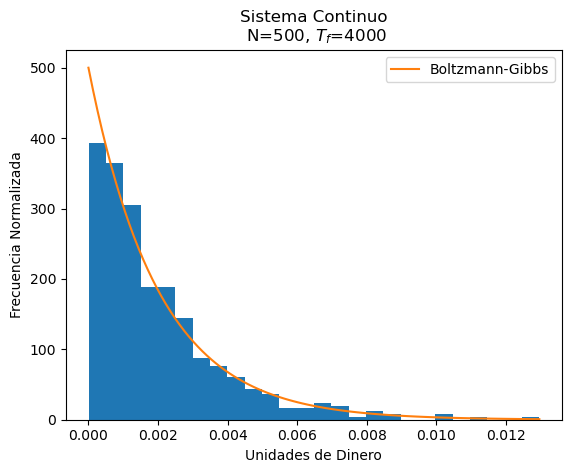

In [8]:
##Inicialización de semillas
np.random.seed(43)

##Prueba de simulación
prueba21 = sistema2()
prueba21.simular(tiempo = 4*10**3)
prueba21.graficar()
plt.show()
prueba21.generar_gif('modelo2simulacion1', density = True)

# Gif de comparación Sistema Discreto vs Sistema Continuo

In [9]:
tiemp = 10**5

#Simulaciones de ambos Sistemas
a = sistema1()
b = sistema2(normal = False)
a.simular(tiempo = tiemp)
b.simular(tiempo = tiemp)
m1 = a.cadena()
m2 = b.cadena()

In [10]:
#Parámetros
N = 500
M = 5*10**5
T = M/N
f = lambda x: (1/T)*np.exp(-x/T)

#Creación del gif
nombre_gif = "SimulacionComparativa"
filenames = []
contador=0
for i in np.arange(0,tiemp,tiemp//30):
    contador+=1
    # ploteamos para cada i la distribución en el tiempo i
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5), sharey = True)
    fig.suptitle(f'Evolución Comparativa t={i} \n N={N}, M={M}, $\Delta m$={0.05*M/N},$T_f$={tiemp}')

    lim1 = np.max(m1[:,i])
    v1 = np.linspace(0,lim1,100)
    lim2 = np.max(m2[:,i])
    v2 = np.linspace(0,lim2,100)

    ax1.set_xlabel('Unidades de Dinero')
    ax1.set_ylabel('Frecuencia Normalizada')
    ax1.hist(m1[:,i], density=True)
    ax1.plot(v1,f(v1), label = "Boltzmann-Gibbs")
    ax1.set_title('Dist. Discreta')
    ax1.legend(loc='upper right')

    ax2.set_xlabel('Unidades de Dinero')
    ax2.hist(m2[:,i],density = True)
    ax2.plot(v2,f(v2), label = "Boltzmann-Gibbs")
    ax2.set_title('Dist. Continua')
    ax2.legend(loc='upper right')


    # creamos un nombre para el archivo de la imagen
    filename = f'{contador}.png'
    filenames.append(filename)

    # en el último tiempo creamos varias replicas para congelar la imagen
    if (i == np.arange(0,tiemp,tiemp//30)[-1]):
        for i in range(15):
            filenames.append(filename)
    # guardamos el(los) frame(s)
    plt.savefig(filename)
    plt.close()# build gif
with imageio.get_writer(nombre_gif+'.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

# eliminamos los archivos creados
for filename in set(filenames):
    os.remove(filename)

# Modelo con firmas

Cada tiempo un agente se convierte en firma, que pide capital $K$ a otro agente y lo devuelve con interés $rK$, contrata $L$ agentes y les paga sueldos $W$, manufactura $Q$ items de un producto y los vende a $Q$ agentes a un precio $R$. Todos estos agentes se seleccionan aleatoriamente, la firma recibe una ganancia 
$$
F = RQ − LW − rK.
$$

In [11]:
class sistema3: 
    #Método iniciador (pars = [F,rK,R,Q,W,L])
    def __init__(self, N = 500, M = 5*10**5, pars = [68, 52, 32, 10, 10, 20]):
        self.F, self.rK, self.R, self.Q, self.W, self.L = pars
        self.N = N #Número de agentes
        self.M = M # Cantidad de dinero en circulación
       
    #Método que dado un tiempo tau, samplea a los agentes involucrados que satisfagan las 
    #restricciones de dinero
    def sampleo(self, tau):#samplea a los agentes involucrados que satisfagan las restricciones de dinero
        vec = np.arange(0,self.N)
        vec = vec[self.mm[:,tau]>=self.R] #Filtramos sólamente los agentes que puedan comprar el producto 
        agents = np.random.choice(vec,2 + self.Q + self.L) #elegimos a la firma, el prestamista, los consumidores y los empleados, todos distintos
        return agents

    #Método que realiza la simulación en con tiempo 
    def simular(self, tiempo = 4*10**5):
        self.tiempo = tiempo
        self.mm = np.zeros([self.N, self.tiempo])
        self.mm[:,0] = np.ones(self.N)*(self.M/self.N)
        for t in range(1,self.tiempo):
            self.mm[:,t] += self.mm[:,t-1]
            agentes = self.sampleo(t) 
            self.mm[agentes[0],t]+= self.F #Empleador
            self.mm[agentes[1],t]+= self.rK #Prestamista
            #Compradores
            for comprador in agentes[2:12]:
                self.mm[comprador,t]-= self.R 
            #Empleados
            for empleado in agentes[12:]:
                self.mm[empleado,t]+= self.W  
                
    #Método que retorna la evolución de los estados
    def cadena(self):
        return self.mm
    
    #Método que genera la distribución empírica y la distribución BG normalizada a los estados finales 
    #### quizá esto debería ir en simular y guardarse en estados de la clase ####
    def distribuciones(self, tau = -1):
        ### Densidad Empírica
        cadena_en_tau = self.mm[:,tau].copy()
        estados, frec =  np.unique(cadena_en_tau, return_counts=True) #valores únicos de riqueza y su 
                                                                     #frecuencia absoluta
        dist_emp = frec/np.sum(frec) #densidad empírica de probabilidad (frecuencia relativa de aparición)
        #La probabilidad de que un agente tenga estados[i] plata es dist_emp[i]
        
        ###Densidad modelo: pi \prop exp(-x/T)
        ##pi(x) = exp(-x/T)/ [sum_{i\in estados} exp(-i/T)
        T = self.M/self.N
        cte_norm = np.sum([np.exp(-i/T) for i in estados])
        pi = lambda x: (1/cte_norm)*np.exp(-x/T)
        
        return dist_emp, pi(estados)
    
    #Método que retorna el error cuadrático medio entre distribución empírica y distribución modelada
    def ECM(self, tau = -1):
        dist_emp, dist_modelo = self.distribuciones(tau)
        return np.square(dist_emp-dist_modelo).mean()
    
    #Método que grafica la distribución de dinero en tiempo tau
    def graficar(self, tau = -1, par_bins='auto', density = True):
        plt.title(f' Sistema con Firmas \n N={self.N}, M={self.M}, $T_f$={self.tiempo}')
        if density==True:
            plt.hist(self.mm[:,tau], bins= par_bins, density = True)
            
            T = self.M/self.N
            f = lambda x: (1/T)*np.exp(-x/T)
            lim = np.max(self.mm[:,tau])
            v = np.linspace(0,lim,100)
            plt.plot(v,f(v), label = "Boltzmann-Gibbs")
            plt.legend(loc='upper right')
            plt.xlabel('Unidades de Dinero')
            plt.ylabel('Frecuencia Normalizada')
        else:
            plt.hist(self.mm[:,tau], bins= par_bins)
            
    #Método que genera un gif con la evolución del sistema
    def generar_gif(self,nombre_gif, par_bins='auto', density = True):
        ### GIF de la evolución del sistema
        filenames = []
        contador=0
        for i in np.arange(0,self.tiempo,self.tiempo//30):
            contador+=1
            # ploteamos para cada i la distribución en el tiempo i
            plt.title(f'Sistema con Firmas \n N={self.N}, M={self.M}, $T_f$={self.tiempo}')
            if density==True:
                plt.hist(self.mm[:,i], bins= par_bins, density = True)
            
                T = self.M/self.N
                f = lambda x: (1/T)*np.exp(-x/T)
                lim = np.max(self.mm[:,-1])
                v = np.linspace(0,lim,100)
                plt.plot(v,f(v), label = "Boltzmann-Gibbs")
                plt.legend(loc='upper right')
                plt.xlabel('Unidades de Dinero')
                plt.ylabel('Frecuencia Normalizada')
            else:
                plt.hist(self.mm[:,i], bins=par_bins)
                
            # creamos un nombre para el archivo de la imagen
            filename = f'{contador}.png'
            filenames.append(filename)

            # en el último tiempo creamos varias replicas para congelar la imagen
            if (i == np.arange(0,self.tiempo,self.tiempo//30)[-1]):
                for i in range(15):
                    filenames.append(filename)
            # guardamos el(los) frame(s)
            plt.savefig(filename)
            plt.close()# build gif
        with imageio.get_writer(nombre_gif+'.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.v2.imread(filename)
                writer.append_data(image)

        # eliminamos los archivos creados
        for filename in set(filenames):
         lo en relaci ́on a las simu   os.remove(filename)

### Resultado

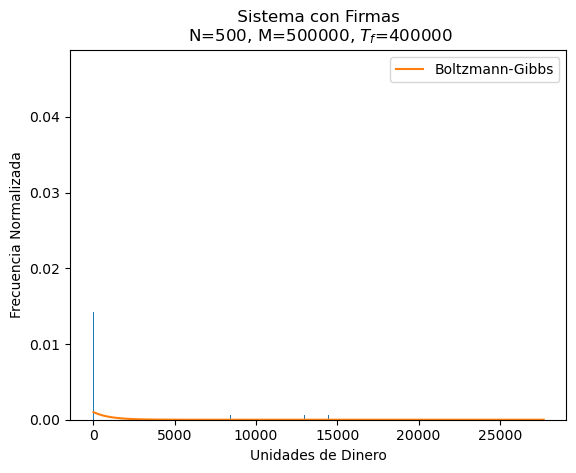

In [12]:
##Inicialización de semillas
np.random.seed(43)

##Prueba de simulación
prueba31 = sistema3()
prueba31.simular(tiempo = 4*10**5)
prueba31.graficar()
plt.show()
prueba31.generar_gif('modelo3simulacion1', density = True)

In [13]:
prueba31.ECM()

0.00041045298598277303

### Evolución del error cuadrático

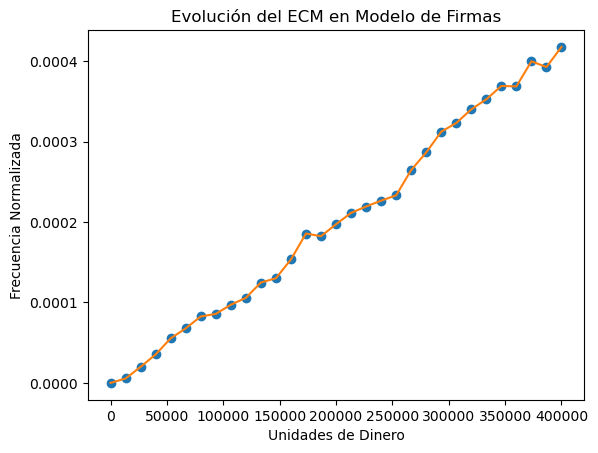

In [14]:
tiempo = 4*10**5
v = np.arange(0,tiempo,tiempo//30)
ecms = [prueba31.ECM(i) for i in v]

plt.plot(v[:],ecms[:], "o")
plt.plot(v[:],ecms[:])

plt.title('Evolución del ECM en Modelo de Firmas')
plt.xlabel('Unidades de Dinero')
plt.ylabel('Frecuencia Normalizada')
plt.show()